In [48]:
import pandas as pd
import numpy as np

from scipy.stats import randint
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

In [ ]:
df = pd.read_csv("Customer-Churn-Records.csv")
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,1,5,DIAMOND,484
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0,0,2,SILVER,206
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,1,2,DIAMOND,282
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,0,3,GOLD,251
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0,0,3,GOLD,342


In [50]:
df.drop(columns=["RowNumber", "CustomerId", "Surname", 'Complain'], inplace=True)
# first three features are useless, the last one may cause the Data Leakage (this variable is highly correlated with the target variable (Exited))

cat_cols = ["Geography", "Gender", "Card Type"]
for c in cat_cols:
    df[c] = df[c].astype("category")


In [51]:
X = df.drop("Exited", axis = 1)  # target feature 
y = df["Exited"]
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,5,GOLD,425


In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.2, random_state = 42, stratify = y)

In [53]:
base = LGBMClassifier(
    n_estimators = 2000,
    objective = "binary",
    random_state = 42,
    n_jobs = -1
)

param_grid = {
    "model__n_estimators" : randint(400, 1200),
    "max_depth": randint(-1, 16),
    "num_leaves": randint(16, 256)
}

In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator = base,
    param_distributions = param_grid,
    n_iter = 30,
    scoring = "roc_auc",
    cv = cv,
    random_state = 42,
    n_jobs = -1
)

In [55]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
print("Best AUC:", search.best_score_)
print("Best params:", search.best_params_)

Best AUC: 0.8295971005062732
Best params: {'max_depth': 1, 'model__n_estimators': 884, 'num_leaves': 66}


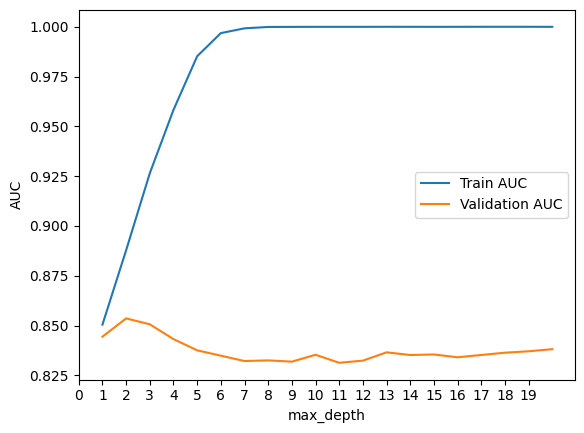

In [ ]:
import matplotlib.pyplot as plt

# verify the best params manually. Here I just take max_depth for example, verification of other feathers will be the same
auc_list_train = []
auc_list_val = []

max_depth_list = np.arange(1, 21)

for max_depth in max_depth_list:
    model = LGBMClassifier(
        max_depth=max_depth,
        random_state=42
    )

    model.fit(X_train, y_train)

    pred_train = model.predict_proba(X_train)[:, 1] #  exited = 1
    pred_val = model.predict_proba(X_val)[:, 1]

    auc_train = roc_auc_score(y_train, pred_train)
    auc_val = roc_auc_score(y_val, pred_val)

    auc_list_train.append(auc_train)
    auc_list_val.append(auc_val)

plt.figure()
plt.plot(max_depth_list, auc_list_train, label="Train AUC")
plt.plot(max_depth_list, auc_list_val, label="Validation AUC")
plt.xlabel('max_depth')
plt.ylabel('AUC')
plt.xticks(ticks = range(len(max_depth_list)))
plt.legend()
plt.show()
# we can see from the figure that a turning point appears at max_depth = 2


In [63]:
import shap

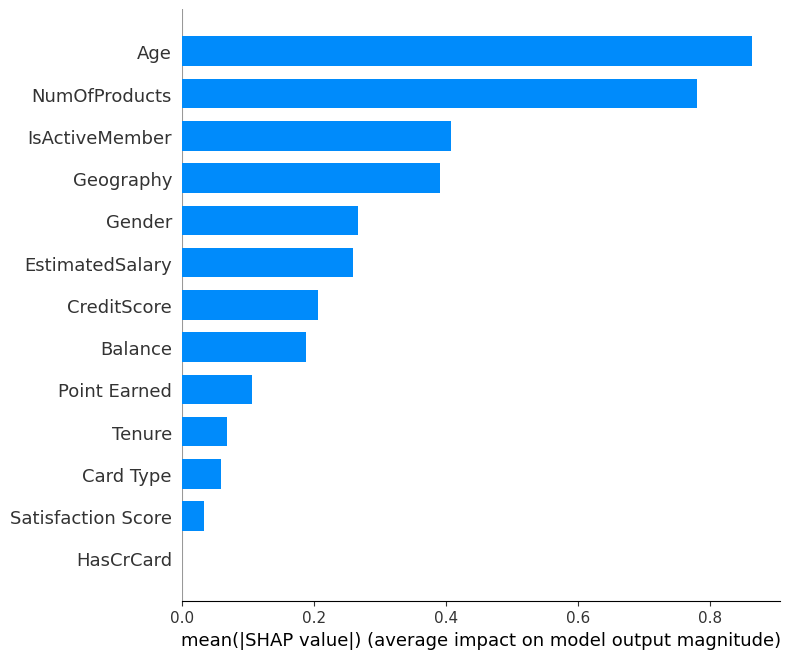

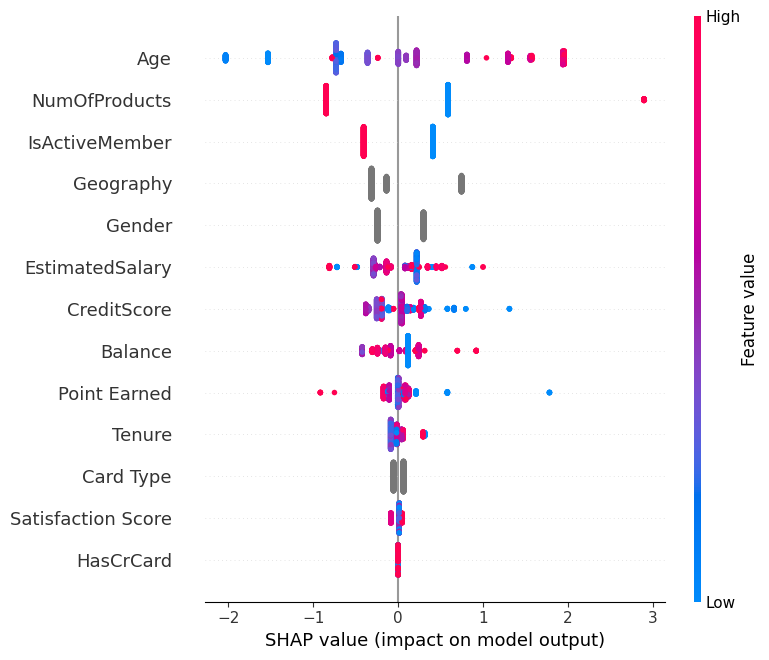

In [64]:
explainer = shap.TreeExplainer(best_model)
X_sample = X_val.sample(1000, random_state=42) if len(X_val) > 1000 else X_val

sv = explainer(X_sample)
# in case of binary : shape of sv.values may be (n, m, 2)
vals = sv.values
if vals.ndim == 3:
    vals = vals[:, :, 1]  # exited = 1

shap.summary_plot(vals, X_sample, plot_type="bar", max_display=20)
shap.summary_plot(vals, X_sample, max_display=20)
# if we do not drop the feature "complain", we will see that the influence of "complain" is overwhelming


In [108]:
#  Compare with other models
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

In [90]:
df2 = df.copy()
df2.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


In [91]:
X = df2.drop("Exited", axis = 1)
y = df2["Exited"]
cat_cols = ["Geography", "Gender", "Card Type"]
num_cols = [c for c in X.columns if c not in cat_cols]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [107]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols), #  drop="first" better for LogisticRegression
        ("num", StandardScaler(), num_cols), 
    ],
    remainder="drop"
)

In [94]:
models = {
    "Logistic": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [106]:
results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("prep", preprocess),
        ("model", model)
    ])
    
    cv_scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        cv = cv,
        scoring = "roc_auc",
        n_jobs = -1
    )  # use cross validation
    
    pipe.fit(X_train, y_train)
    pred_test = pipe.predict_proba(X_test)[:,1]
    auc_test = roc_auc_score(y_test, pred_test)

    results[name] = {
        "CV Mean AUC": np.mean(cv_scores),
        "CV Std": np.std(cv_scores),
        "Test AUC": auc_test
    }

d:\Anaconda\envs\bank_churn\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


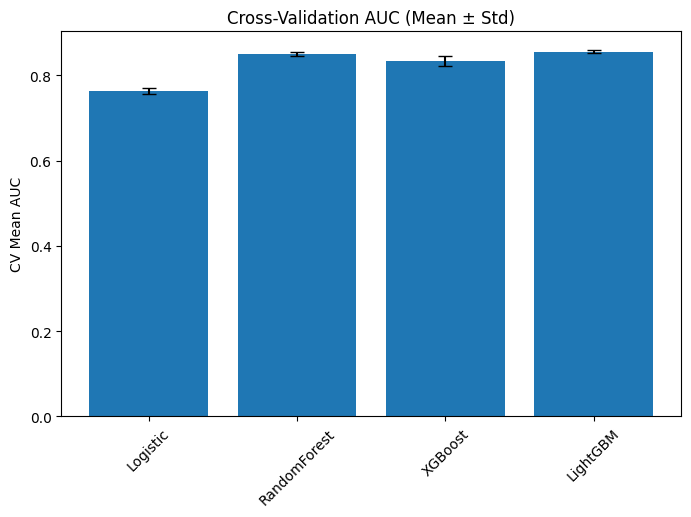

In [ ]:
df_results = pd.DataFrame(results).T
plt.figure(figsize=(8,5))
plt.bar(
    df_results.index,
    df_results["CV Mean AUC"],
    yerr=df_results["CV Std"],
    capsize=5
)

plt.ylabel("CV Mean AUC")
plt.title("Cross-Validation AUC (Mean ± Std)")
plt.xticks(rotation=45)
plt.show()
#  LightGBM ≈ RandomForest > XGBoost >> Logistic

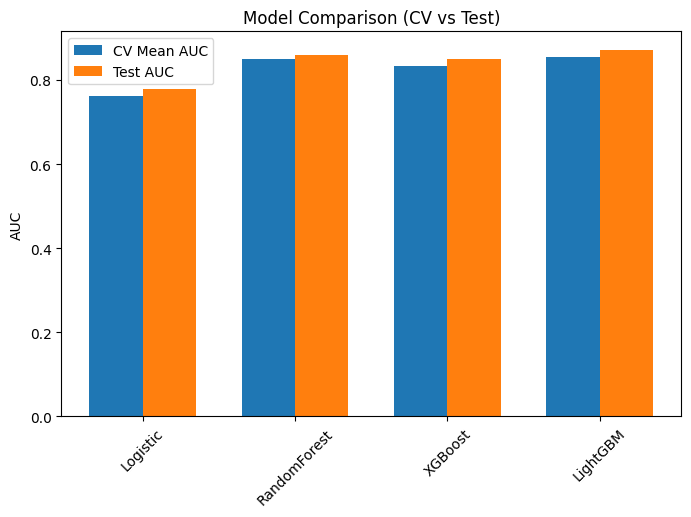

In [ ]:
x = np.arange(len(df_results))
width = 0.35

plt.figure(figsize=(8,5))

plt.bar(x - width/2, df_results["CV Mean AUC"], width, label="CV Mean AUC")
plt.bar(x + width/2, df_results["Test AUC"], width, label="Test AUC")

plt.xticks(x, df_results.index, rotation=45)
plt.ylabel("AUC")
plt.title("Model Comparison (CV vs Test)")
plt.legend()
plt.show()
#  neither overfitting nor overfitting

In [114]:
#  clustering by K-means
from sklearn.cluster import KMeans

In [115]:
cluster_features = [
    "Age",
    "Balance",
    "NumOfProducts",
    "IsActiveMember",
    "EstimatedSalary",
    "Tenure"
]
X_cluster = df2[cluster_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

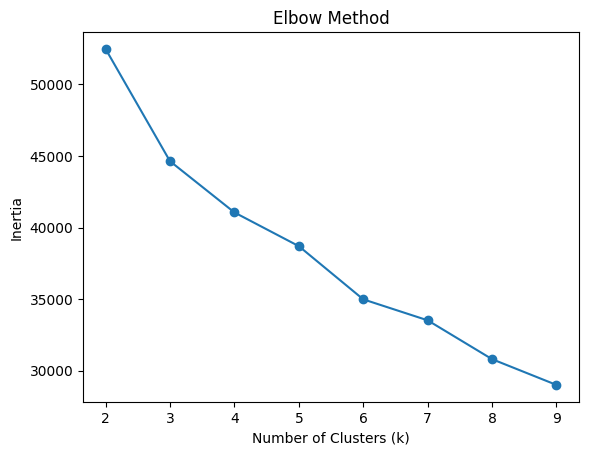

In [ ]:
#  looking for a best k value using the elbow method
inertia_list = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    inertia_list.append(kmeans.inertia_)

plt.figure()
plt.plot(range(2,10), inertia_list, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()
#  The elbow appears at k = 3

In [122]:
#  Using PCA to reduce the dimension and present the figure
from sklearn.decomposition import PCA

In [123]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df2["Cluster"] = clusters

In [124]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

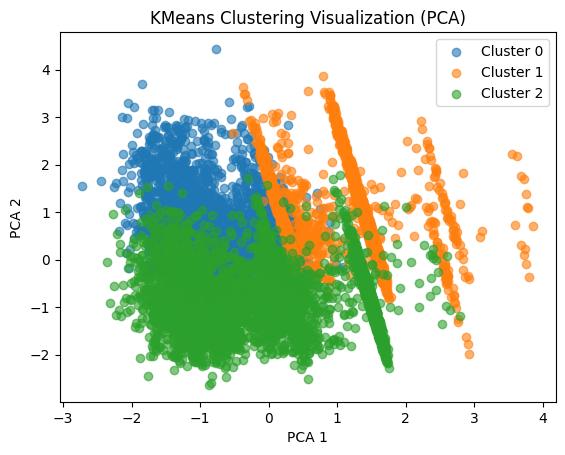

In [129]:
plt.figure()

for cluster in range(3):
    plt.scatter(
        X_pca[df2["Cluster"] == cluster, 0],
        X_pca[df2["Cluster"] == cluster, 1],
        label=f"Cluster {cluster}",
        alpha=0.6
    )

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans Clustering Visualization (PCA)")
plt.legend()
plt.show()


In [ ]:
df2.groupby("Cluster")[[
    "Age",
    "NumOfProducts",
    "IsActiveMember",
    "Balance",
    "Exited"
]].mean()

#  the last cluster has the biggest proba of exiting

,Age,NumOfProducts,IsActiveMember,Balance,Exited
Cluster,,,,,
0,39.697030,1.293961,1.000000,122389.332279,0.154821
1,39.995036,1.908394,0.972022,11047.700749,0.143953
2,37.939628,1.503029,0.000000,78039.765862,0.262168
